Résolution de la courbe de remous
=============================

Ce script jupyter résout l'exemple de la section 5.3.3 du cours. On considère un aménagement composé :
- d'un réservoir avec une vanne de 2 m de hauteur laissant passer un débit $q=10$ m$^2$/s en O ;
- d'un coursier en pente raide ($i_1=5$ \%) et moyennement rugueux (coefficient de Chézy $C=50$ m$^{1/2}$ s$^{-1}$), d'une longueur de 10 m entre O et A ;
- d'un canal de pente douce ($i_1=0,2$ \%) et de même rugosité rugueux que le coursier $C=50$ m$^{1/2}$ s$^{-1}$, d'une longueur de 1000 m entre A et B ;
- d'un seuil d'une pelle $p=0,5$ m en B.
Le coursier et le canal sont suffisamment larges pour qu'on néglige les effets de paroi.

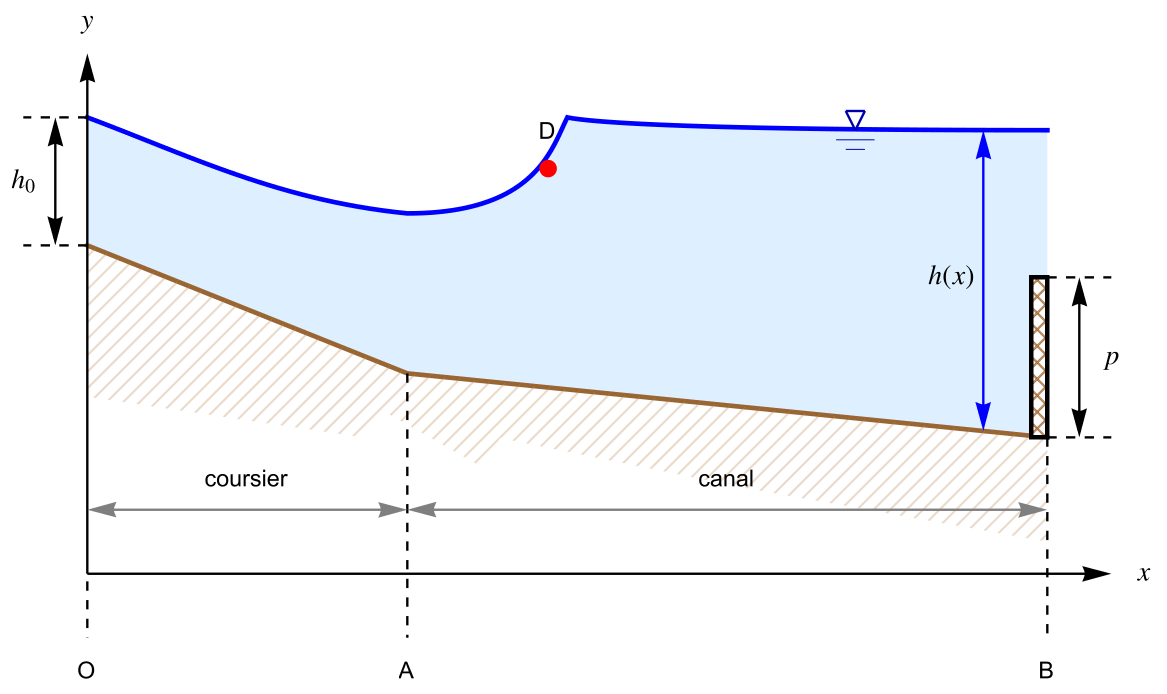

In [1]:
# initialisation
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import LineString
# ce script nécessite la bibliothèque "shapely" pour calculer l'intersection de deux courbes. Si elle n'est pas
# installée, il faut l'installer, p. ex. avec la commande : pip install shapely
 
# paramètres generaux
# gravité
g = 9.81
# débit par unité de largeur
q = 10
# Chézy
Ch = 50

# paramètres du bief 1
i1 = 0.05
h0 = 2
x0 = 0
xA = 10

# paramètres du bief 2
i2 = 0.002
p = 0.5
xB = 1000 + xA

Pour chacun des biefs, on calcule le nombre de Froude
$$
\mathrm{Fr}=\frac{q}{\sqrt{gh^3}},
$$
la hauteur critique
$$
h_c=\sqrt[3]{\frac{q^2}{g}},
$$
et la hauteur normale
$$
h_n=\left(\frac{q}{C\sqrt{i}}\right)^{2/3}.
$$
Pour le nombre de Froude, on calcule le nombre de Froude associé à la hauteur normale ($h=h_n$) et celui associé à la condition aux limites ($h=h_0$).

In [2]:
## calcul des conditions hydrauliques dans le bief 1
hn1 = (q / Ch / np.sqrt(i1)) ** (2 / 3)
Frn1 = q / hn1 ** 1.5 / np.sqrt(g)
hc1 = (q ** 2 / 9.81) ** (1 / 3)
Fr1 = q / 2 ** 1.5 / np.sqrt(g)

print("*** bief 1 (coursier) ***")
print("Hauteur normale :",f"{hn1:.2} m") 
print("Hauteur critique :",f"{hc1:.2} m") 
print("Froude à l'entrée :",f"{Fr1:.2}")
print("Froude asymptotique :",f"{Frn1:.2}") 

# calcul des conditions hydrauliques dans le bief 2
hn2 = (q / Ch / np.sqrt(i2)) ** (2 / 3)
Frn2 = q / hn2 ** 1.5 / np.sqrt(g)
hc2 = (q ** 2 / 9.81) ** (1 / 3)
##solution de la courbe de remous (équation de Besse)
# sur l'intervalle [0, xA]

print("*** bief 2 (canal) ***")
print("Hauteur normale :",f"{hn2:.2} m") 
print("Hauteur critique :",f"{hc2:.2} m") 
print("Froude asymptotique :",f"{Frn2:.2}") 


*** bief 1 (coursier) ***
Hauteur normale : 0.93 m
Hauteur critique : 2.2 m
Froude à l'entrée : 1.1
Froude asymptotique : 3.6
*** bief 2 (canal) ***
Hauteur normale : 2.7 m
Hauteur critique : 2.2 m
Froude asymptotique : 0.71


## Courbe de remous dans le coursier

On cherche maintenant à résoudre l'équation de la courbe de remous le long du coursier entre O et A. 

Lorsque le frottement est de type Chézy, cette équation peut se mettre sous la forme équivalente
$$ 
h'=F(h)=i\frac{1-(h_n/h)^3}{1-(h_c/h)^3},
$$
avec pour condition limite à l'amont (régime supercritique)
$$
h(0)=h_0=2\text{ m}.
$$
Pour résoudre cette équation différentielle, on se sert de la méthode d'Euler à l'ordre 1 qui est une méthode iterative qui résout l'équation différentielle de proche en proche en déterminant la valeur de $h$ en $x_i$ le long d'une grille $x_i=x_0+i\delta x$  
$$
h(x_{n+1})=h(x_n)+F(h_n)\delta x, h(x_0)=h_0.
$$
Cette forme provient simplement de la discrétisation de l'équation différentielle
$$
h'=\frac{\mathrm{d} h}{\mathrm{d} x}=\lim_{\delta x\to0} \frac{h(x_{n+1})-h(x_{n })}{\delta x}.
$$



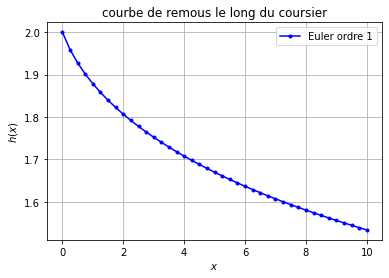

In [3]:
# définition de la fonction de Besse
def besse(x,y,slope,hn,hc): 
    ydot = slope * (1 - (hn / y) ** 3) / (1 - (hc / y) ** 3)
    return ydot

# définition de la méthode de résolution d'Euler (schéma amont)
def BesseEuler(x,y0,slope,hn,hc):
    y = np.zeros(len(x))
    y[0] = y0
    for n in range(0,len(x)-1):
        y[n+1] = y[n] + besse(x[n],y[n],slope,hn,hc)*(x[n+1] - x[n])
    return y

# résolution avec un pas delta_x de 25 cm
xi=x0;xf = xA; DeltaX = .25; 
# nombre de mailles
N = int((xf - xi)/DeltaX);
# maillage de x
xCoursier = np.linspace(x0,xf,N+1); 
# condition aux limites amont
y0 = h0;
# solution
yCoursier = BesseEuler(xCoursier,y0,i1,hn1,hc1)
# tracé
plt.plot(xCoursier,yCoursier,'b.-'), plt.grid(True)
plt.xlabel("$x$")
plt.ylabel("$h(x)$")

plt.title("courbe de remous le long du coursier"), plt.legend(["Euler ordre 1"])
plt.show()

## Courbe de remous dans le canal : branche supercritique
Il faut maintenant résoudre l'équation différentielle de la courbe de remous dans le second bief. On commence en A. L'écoulement arrive du coursier. C'est la hauteur d'eau calculée en A précédemment qui va servir de condition aux limites amont (l'écoulement étant supercritique, on fixe toujours cette condition à l'amont).

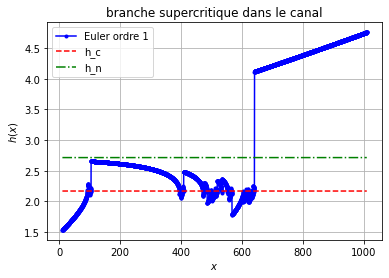

In [4]:
# Condition limite amont
hA=yCoursier[-1]
# résolution avec un pas delta_x de 25 cm
xi=xA;xf = xB; DeltaX = .25; N = int((xf - xi)/DeltaX);
xSuper = np.linspace(xi,xf,N+1); y0 = hA;

ySuper = BesseEuler(xSuper,y0,i2,hn2,hc1)
plt.plot(xSuper,ySuper,'b.-'), plt.grid(True)
plt.plot(xSuper,hc2*np.ones(len(xSuper)),'r--')
plt.plot(xSuper,hn2*np.ones(len(xSuper)),'g-.')
plt.xlabel("$x$")
plt.ylabel("$h(x)$")
plt.title("branche supercritique dans le canal"), plt.legend(["Euler ordre 1","h_c","h_n"])
plt.show()

Manifestement il y a un souci... C'est normal : lorsque $h$ s'approche de la hauteur critique $h_c$, le dénominateur tend vers 0, et donc $F(h)\to\infty$. Il y a une singularité dans la courbe de remous qui est due à la présence d'un ressaut hydraulique. On ne va donc conserver que la première partie de la solution où $h<h_c$ (rappel $h_c=2{,}2$ m).

In [5]:
xSuper=xSuper[ySuper<2.2]
ySuper=ySuper[ySuper<2.2]
 

## Courbe de remous dans le canal : branche subcritique
On va maintenant examiner l'autre branche, la branche subcritique. Pour résoudre l'équation de Besse, il faut maintenant une condition aux limites fixée à l'aval. Pour connaître cette condition, nous devons estimer la hauteur au point B, plus exactement dans le voisinage immédiat à l'amont de B (seuil). Pour cela, on va calculer la charge hydraulique en B
$$
H_B =p+h+\frac{u^2}{2g} = p+h+\frac{q^2}{2gh^2}
$$
puisque $u=q/h$. La hauteur au-dessus du seuil est la hauteur critique, donc en B 
$$
h=h_c= \sqrt[3]{\frac{q^2}{g}}
\text{ ou bien }
q^2=gh^3.
$$
La charge en B est donc
$$
H_B =p+h+\frac{u^2}{2g} = p+\frac{3}{2}h_c=p+\frac{3}{2}\sqrt[3]{\frac{q^2}{g}}.
$$
On calcule cette charge. Puis après cela, on se place juste à l'amont du point B. Sur de courbes distances, la charge hydraulique ne varie pas, mais la cote du lit passe de $p$ à 0, et la hauteur passe de $h_c$ à une nouvelle hauteur que l'on va appeler (un peu improprement) $h_B$
$$
H_B=0+h_B+\frac{q^2}{2gh^2_B}.
$$
C'est un polynôme de degré 3 en $h_B$ :
$$
 h_B^3-H_Bh^2_B+\frac{q^2}{2g}=0
$$
On se sert de la fonction roots de la bibliothèque numpy pour trouver les racines de cette équation. Il y en a trois, mais une seule racine est réelle, positive, et associée à un régime subcritique ($h>h_c$).

Charge hydraulique en B :  3.75 m
solutions possibles pour les hauteurs :  [3.28 1.51 -1.03]  m


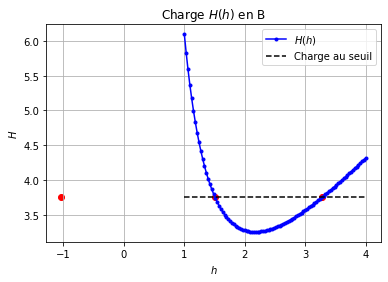

In [38]:
# Charge en B
Hb=p+q**(2/3)*1.5/g**(1/3)
print(f"Charge hydraulique en B : {Hb: .3} m")
coefs=[1,-Hb,0,q**2/g/2]
# Hauteurs possibles à l'amont du seuil
sol=np.roots(coefs)
np.set_printoptions(suppress = True,
   formatter = {'float_kind':'{:0.2f}'.format})
print("solutions possibles pour les hauteurs : ", sol," m")

h = np.linspace(1,4,100) 
H = h+(q/h)**2/2/g
plt.plot(h,H,'b.-'), plt.grid(True)
plt.plot(h,Hb*np.ones(len(h)),'k--')
plt.xlabel("$h$")
plt.ylabel("$H$")
plt.title("Charge $H(h)$ en B"), plt.legend(["$H(h)$","Charge au seuil"])
plt.scatter(sol,Hb*np.ones(3),color='r')
plt.show()

On voit que seule la première racine $h_B=3{,}28$ m satisfait à ces conditions. Cela sera la condition limite à l'aval que l'on va utiliser pour résoudre l'équation de Besse. On voit qu'en intégrant l'équation de Besse dans le sens inverse de l'écoulement (donc de la droite vers la gauche), la hauteur $h(x)$ tend vers la hauteur normale $h_n$

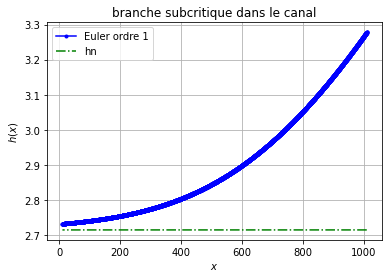

In [7]:
hB=sol[0]
# paramètres de l'équation de Besse (on résout de la droite vers la gauche)
xi = xB; xf=xA;DeltaX = .25; N = int(-(xf - xi)/DeltaX);
xSub = np.linspace(xi,xf,N+1); y0 = hB;

ySub = BesseEuler(xSub,y0,i2,hn2,hc1)
plt.plot(xSub,ySub,'b.-'), plt.grid(True)
plt.plot(xSub,hn2*np.ones(len(xSub)),'g-.')
plt.xlabel("$x$")
plt.ylabel("$h(x)$")

plt.title("branche subcritique dans le canal"), plt.legend(["Euler ordre 1","hn"])
plt.show()

## Position du ressaut
On va maintenant positionner le ressaut. Pour cela, on se sert de la méthode de la courbe conjuguée : on calcule la conjuguée de la branche supercritique, puis on détermine le point d'intersection D de cette conjuguée et de la branche subcritique.

In [8]:

# définition de la courbe conjuguée
def conjugaison(h,q):
    y = 0.5*h*(np.sqrt(8*(q/h**1.5/np.sqrt(g))**2+1)-1)
    return y

yConj=conjugaison(ySuper,q)

In [33]:
# polylignes représentant les branches subcritique et conjuguée
brancheSub=LineString(np.column_stack((xSub,ySub)))
brancheCon=LineString(np.column_stack((xSuper,yConj)))
inter=brancheSub.intersection(brancheCon)
xD, yD=inter.xy 
print(f"position du ressaut : {xD[0]: .3} m")
print(f"hauteur aval du ressaut : {yD[0]: .3} m")
print(f"hauteur amont du ressaut : {ySuper[(xSuper <xD[0])][-1]: .3} m")

position du ressaut :  39.1 m
hauteur aval du ressaut :  2.73 m
hauteur amont du ressaut :  1.69 m


On peut maintenant tracer la solution. On ne reporte ici que les cent premiers mètres.

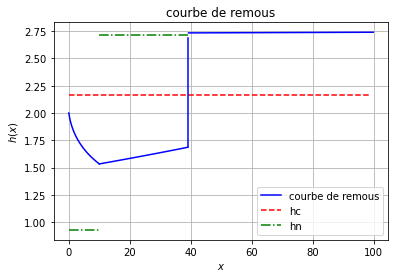

In [25]:
xlim=100
NewXSuper=xSuper[xSuper<xD[0]]
NewYSuper=ySuper[xSuper<xD[0]]

NewXSub=xSub[(xSub>=xD[0])&(xSub<xlim)]
NewYSub=ySub[(xSub>=xD[0])&(xSub<xlim)]

yRessaut=np.arange(NewYSuper[-1],yD[0],.1)
xRessaut=xD[0]*np.ones(len(yRessaut))

xhc=np.arange(0,xlim,1)
yhc=hc1*np.ones(len(xhc))

plt.plot(xCoursier,yCoursier,'b-'), plt.grid(True)
plt.plot(xhc,yhc,'r--')
plt.plot(xCoursier,hn1*np.ones(len(xCoursier)),'g-.')

plt.title("courbe de remous"), plt.legend(["courbe de remous","hc","hn"])

plt.plot(NewXSuper,NewYSuper,'b-')
plt.plot(NewXSub,NewYSub,'b-')
plt.plot(xRessaut,yRessaut,'b-')

plt.plot(NewXSuper,hn2*np.ones(len(NewXSuper)),'g-.')
plt.xlabel("$x$")
plt.ylabel("$h(x)$")

plt.show()

1.6860073430150146